# EXERCISE 6

# SETUP

In [1]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import MSELoss, L1Loss
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.io import write_png

from pytorch_msssim import SSIM

c:\Users\omera\.conda\envs\ML2\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),


In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Use CPU

# Print the device being used
print("Device:", device)

Device: cuda


## DEFINE DATASET & MODEL

In [3]:
# Define class SRDataset
class SRDataset(Dataset):
    def __init__(self, folder_path, augment, interpolation):
        self.folder_path = folder_path
        self.image_filenames = os.listdir(folder_path)
        self.t_crop = transforms.Compose([transforms.RandomCrop(64)])
        self.t_colorjitter = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)])
        self.t_downscale = transforms.Compose([transforms.Resize((32, 32), interpolation=interpolation, antialias=True)])
        self.augment = augment
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.folder_path, self.image_filenames[index])
        hr_image = self.t_crop(read_image(image_path) / 255.0)  # Convert to float between 0 and 1
        if(self.augment):
            lr_image = self.t_downscale(self.t_colorjitter(hr_image))
        else:
            lr_image = self.t_downscale(hr_image)
        
        return lr_image, hr_image


In [ ]:
# # Define Model
# class BasicSRModel(nn.Module):
#     def __init__(self, num_inter_blocks):
#         super(BasicSRModel, self).__init__()
        
#         self.conv_blocks = nn.Sequential(nn.ConvTranspose2d(3, 64, kernel_size=4, stride=2, padding=1))
            
#         for i in range(num_inter_blocks):  # Number of intermediate blocks
#             self.conv_blocks.add_module(
#                 f"conv_{i+1}",
#                 nn.Sequential(
#                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#                     nn.LeakyReLU(inplace=True),
#                 )
#             )
        
#         self.conv_blocks.add_module(
#             "last_conv",
#             nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
#         )
    
#     def forward(self, x):
#         x = self.conv_blocks(x)
#         return x

In [4]:
# Define Model
class BasicSRModel(nn.Module):
    def __init__(self, num_inter_blocks):
        super(BasicSRModel, self).__init__()

        
        self.conv_blocks = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
        self.conv_blocks.add_module(
            "first_conv",
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        )


        #self.conv_blocks = nn.Sequential(nn.ConvTranspose2d(3, 64, kernel_size=4, stride=2, padding=1))
            
        for i in range(num_inter_blocks):  # Number of intermediate blocks
            self.conv_blocks.add_module(
                f"conv_{i+1}",
                nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                    nn.LeakyReLU(inplace=True),
                )
            )
        
        self.conv_blocks.add_module(
            "last_conv",
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        upscaled_image = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(x)
        output = self.conv_blocks(x)
        output += upscaled_image  # Add the upscaled image to the output as residual
        
        return output
    
# Create an instance of BasicSRModel
model = BasicSRModel(10)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(num_params)


372803


In [5]:
# Load and initialize the train_dataset
train_datapath = os.path.join(os.path.abspath(''), 'data/train')
train_dataset = SRDataset(train_datapath, augment=True, interpolation=transforms.InterpolationMode.BILINEAR)
train_batch_size = 4
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    )

In [27]:
# Load and initialize the test_dataset
test_datapath = os.path.join(os.path.abspath(''), 'data/eval')
test_dataset = SRDataset(test_datapath, augment=False, interpolation=transforms.InterpolationMode.BICUBIC)
test_batch_size = 9
test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    )

## TRAINING & EVALUATION

In [7]:
# Create an instance of BasicSRModel
model.to(device)

# Define optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)

# Define loss function
loss_function = L1Loss()
loss_function.to(device)

# # Print the model architecture
# print(model)

# # Check number of parameters in model
num_params = 0
for param in model.parameters():
    num_params += param.numel()
print("num_params: " + str(num_params))


num_params: 372803


In [ ]:
writer = SummaryWriter()
number_of_epochs = 50
for epoch in range(number_of_epochs):
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{number_of_epochs}', unit='batch') as tqdm_train_dataloader:
        # TRAIN BATCH
        cum_loss = 0
        for _, (lr_image, hr_image) in enumerate(tqdm_train_dataloader):
            lr_image, hr_image = lr_image.to(device), hr_image.to(device)
            # reset the gradient
            optimizer.zero_grad()
            # forward pass through the model
            hr_prediction = model(lr_image)  
            # compute the loss
            loss = loss_function(hr_prediction, hr_image)
            # backpropagation
            loss.backward()
            # update the model parameters
            optimizer.step()
            # add loss to be displayed at the end of epoch
            cum_loss += loss.item()
        # log training loss
        writer.add_scalar('loss/train', cum_loss / train_batch_size, epoch)


        # EVALUATE BATCH
        cum_l1 = 0.0
        cum_psnr = 0.0
        cum_ssim = 0.0
        with torch.no_grad():
            for _, (lr_image, hr_image) in enumerate(test_dataloader):
                lr_image, hr_image = lr_image.to(device), hr_image.to(device)
                hr_prediction = model(lr_image)
                # L1
                l1_metric = L1Loss()
                l1_metric.to(device)
                l1_i = l1_metric(hr_prediction, hr_image)
                # PSNR
                mse_metric = MSELoss()
                mse_metric.to(device)
                psnr_i = -10 * torch.log10(mse_metric(hr_prediction, hr_image))
                # SSIM
                ssim_metric = SSIM(data_range=1.0)
                ssim_metric.to(device)
                ssim_i = ssim_metric(hr_prediction, hr_image)
                # accumulate metrics
                cum_psnr += psnr_i.item()
                cum_ssim += ssim_i.item() 
                cum_l1 +=  l1_i.item()
            # Log test loss
            writer.add_scalar('loss/test-l1', cum_l1 / test_batch_size, epoch)   
            writer.add_scalar('loss/test-psnr', cum_psnr / test_batch_size, epoch)
            writer.add_scalar('loss/test-ssim', cum_ssim / test_batch_size, epoch)   
    

In [ ]:
# # Save model
# torch.save(model.state_dict(), "saved-models/test.pt")

In [8]:
#Load model
model = BasicSRModel(10)
model.load_state_dict(torch.load("saved-models/model-residual-500.pt"))
model.to(device); # Suppress output

In [ ]:
# Save images for comparison
with torch.no_grad():
    for _, (lr_image, hr_image) in enumerate(test_dataloader):
        lr_image, hr_image = lr_image.to(device), hr_image.to(device)
        hr_prediction = model(lr_image)
        
        # Display images
        lr_image_disp = lr_image.to('cpu')
        hr_image_disp = hr_image.to('cpu')
        hr_prediction_disp = hr_prediction.to('cpu')
        write_png(lr_image_disp[0, ...].mul(255).byte(), "image-outputs/lr_image.png")
        write_png(hr_image_disp[0, ...].mul(255).byte(), "image-outputs/hr_image.png")
        write_png(hr_prediction_disp[0, ...].mul(255).byte(), "image-outputs/hr_prediction.png")

        # Upscale using analytical upscaling methods
        hr_bilinear = transforms.functional.resize(lr_image_disp.squeeze(0), (64, 64), interpolation=2)
        hr_bicubic = transforms.functional.resize(lr_image_disp.squeeze(0), (64, 64), interpolation=3)
        write_png(hr_bilinear[0, ...].mul(255).byte(), "image-outputs/bilinear.png")
        write_png(hr_bicubic[0, ...].mul(255).byte(), "image-outputs/bicubic.png") 
        break

# RESULTS & DISCUSSION

## Residual Connections:

In the following the training / test losses for both models can be seen. The model with residuals is displayed in cyan.

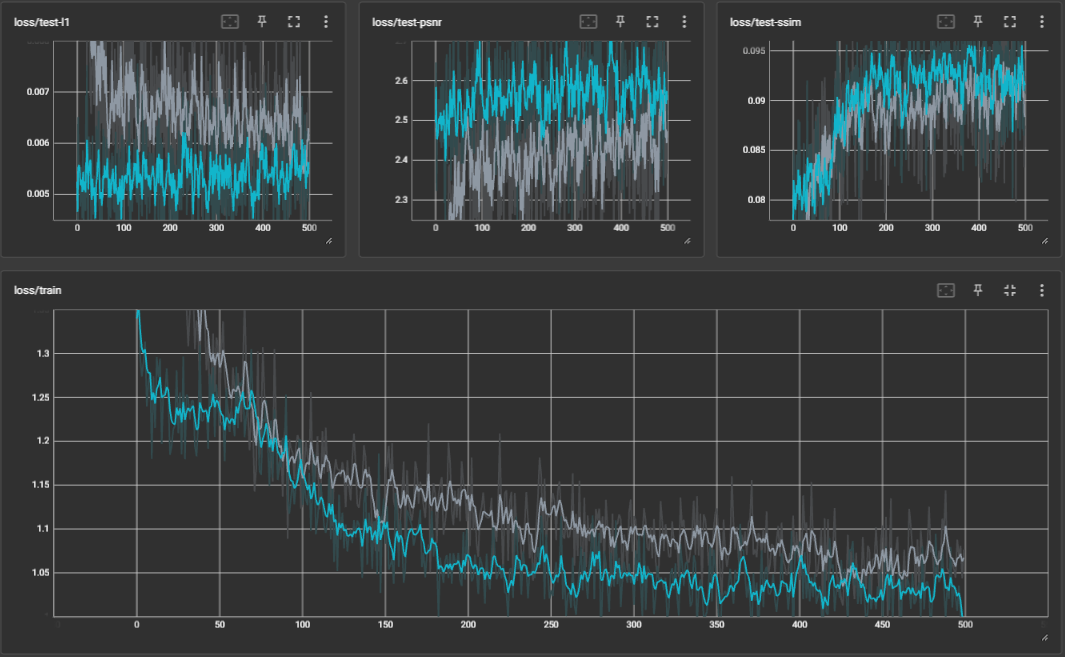

In [46]:
from IPython import display
display.Image("D:\VSCode Git Repos\MFCGV-Projects\MF2023-Exercise6\selected-images\graph_epochs500.png")

We can see that the network with residuals performs better. Here is an example of the prediction obtained from the residual network, compared to analytical methods.

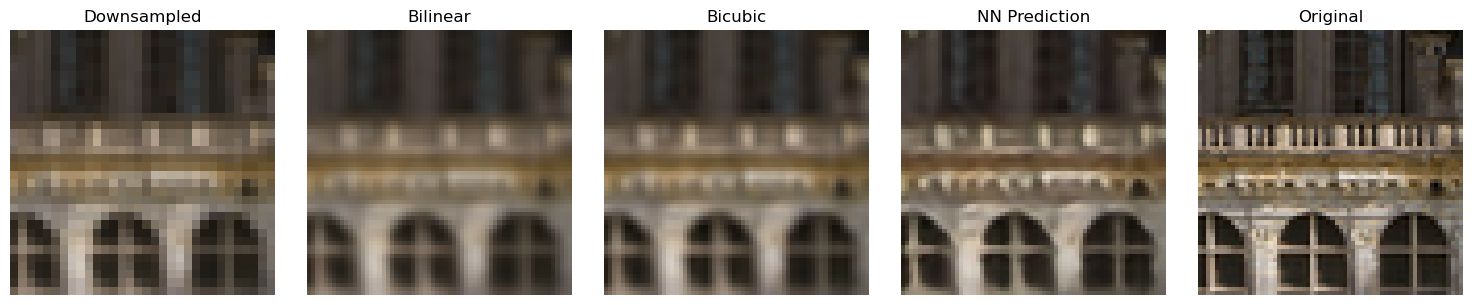

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image file paths
image_paths = [
               'selected-images\wall_lr_image.png',          
               'selected-images\wall_bilinear.png', 
               'selected-images\wall_bicubic.png',
               'selected-images\wall_hr_prediction.png', 
               'selected-images\wall_hr_image.png']
image_titles = ['Downsampled', 'Bilinear', 'Bicubic','NN Prediction', 'Original']

# Create a figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the image paths, titles, and corresponding axes
for i, (image_path, image_title, ax) in enumerate(zip(image_paths, image_titles, axes)):
    # Load and display the image
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(image_title)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Different Learning rates:

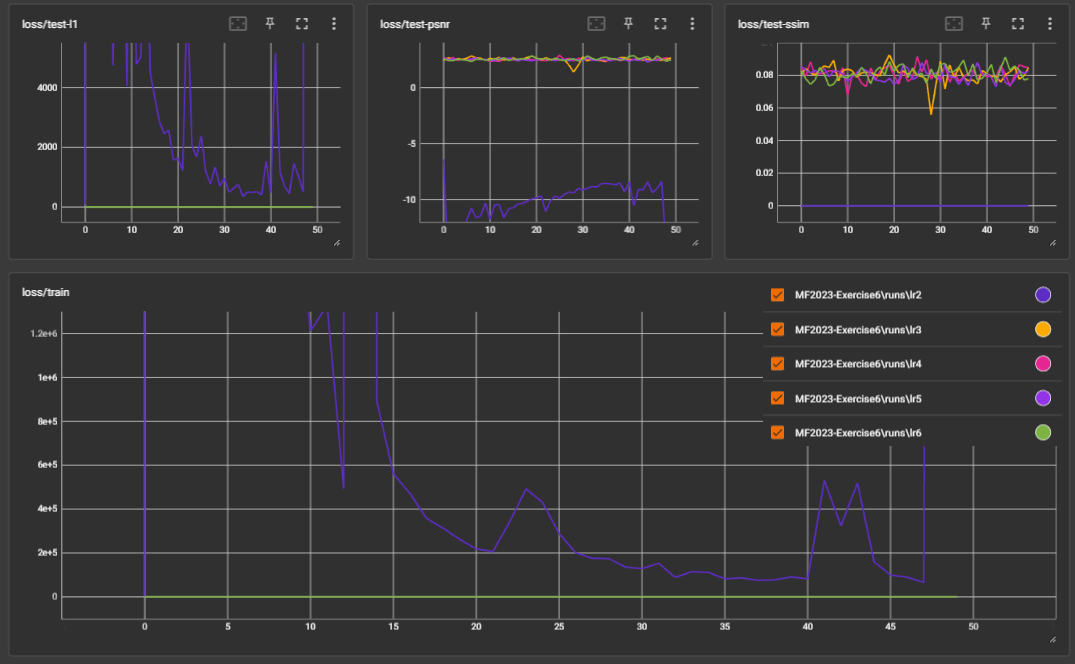

In [2]:
from IPython import display
display.Image("D:\VSCode Git Repos\MFCGV-Projects\MF2023-Exercise6\selected-images\graph_learningrates.png")

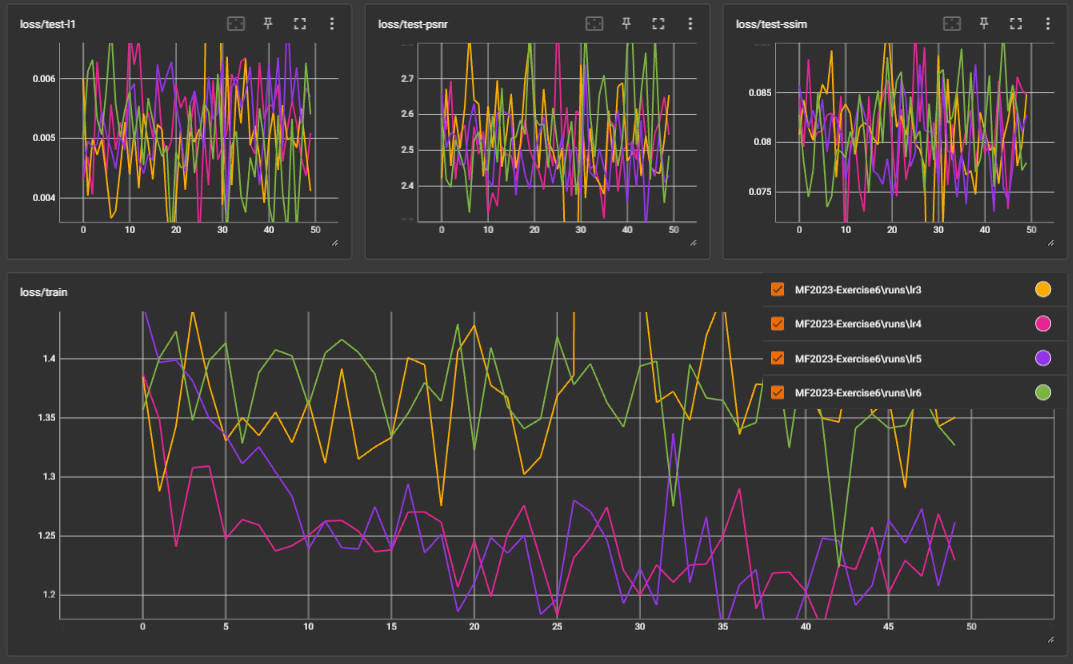

In [3]:
from IPython import display
display.Image("D:\VSCode Git Repos\MFCGV-Projects\MF2023-Exercise6\selected-images\graph_learningrates_detailed.png")

#### Additional discussion:
From these graphs we can see that learning rate 1e-3 still exhibits some erratic behaviour, while the rest of the graphs do not seem to jitter as much. The model with learning rate 1e-2 is so unstable that I had to include two different graphs to show all of the graphs in detail. Surprisingly the model with residual connections seems to do quite well for all three learning rates 1e-4, 1e-5 and 1e-6. In contrast the model without the residuals benefited more from higher learning rates (ex: 1e-4) more. Another observation I have had during this process, is the fact that really high batch sizes (ex: 128, 256) lead to the network outputting single-colour images as the predictions.

In [44]:
# CODE TO TEST EVALUATION WITH DIFFERENT INTERPOLATION MODES
cum_l1 = 0.0
cum_psnr = 0.0
cum_ssim = 0.0
with torch.no_grad():
    for _, (lr_image, hr_image) in enumerate(test_dataloader):
        lr_image, hr_image = lr_image.to(device), hr_image.to(device)
        hr_prediction = model(lr_image)
        # L1
        l1_metric = L1Loss()
        l1_metric.to(device)
        l1_i = l1_metric(hr_prediction, hr_image)
        # PSNR
        mse_metric = MSELoss()
        mse_metric.to(device)
        psnr_i = -10 * torch.log10(mse_metric(hr_prediction, hr_image))
        # SSIM
        ssim_metric = SSIM(data_range=1.0)
        ssim_metric.to(device)
        ssim_i = ssim_metric(hr_prediction, hr_image)
        # accumulate metrics
        cum_psnr += psnr_i.item()
        cum_ssim += ssim_i.item() 
        cum_l1 +=  l1_i.item()
    # Log test loss
    print('loss/test-l1: ' + str(cum_l1 / test_batch_size))  
    print('loss/test-psnr: ' + str(cum_psnr / test_batch_size))  
    print('loss/test-ssim: ' + str(cum_ssim / test_batch_size))  

loss/test-l1: 0.005523323184914059
loss/test-psnr: 2.5547362433539496
loss/test-ssim: 0.09404068522983128


## Different Interpolation Modes:

In the following are some example values for losses obtained through different downsampling methods in test_dataloader. I was expecting the bilinear loss to be drastically less than other methods, since the upscaling in the NN Model is also bilinear. This has mostly been proven false where all the error metrics are closer to each other than expected.

#### Bilinear:

loss/test-l1: 0.006446053998337852

loss/test-psnr: 2.336009979248047

loss/test-ssim: 0.09373752276102702

#### NN:

loss/test-l1: 0.008062282370196449

loss/test-psnr: 1.9553040398491754

loss/test-ssim: 0.07502278354432848

#### Bicubic:

loss/test-l1: 0.005523323184914059

loss/test-psnr: 2.5547362433539496

loss/test-ssim: 0.09404068522983128